<a href="https://colab.research.google.com/github/lokkuuuu/Machine-Learning-for-medical-image-classification/blob/main/BreastHis_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Histology Image Classfication

## Mounting to Google Drive

In [ ]:
#Mount to google drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
#Change to working directory
%cd drive/MyDrive/BreakHis/

/content/drive/MyDrive/BreakHis


## Import Necessary Libraries

In [ ]:
#install required libraries
!pip install scikit-plot
#Import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall

#library for CNN
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Lambda, Input, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

## VGG19


### Function

In [ ]:
IMAGE_SIZE = (224, 340)
CROP_SIZE = (224, 224)
BATCH_SIZE = 128
def dataset(ds_path, *,
            train,
            preprocess_fn=None,
            image_size=IMAGE_SIZE,
            crop_size=CROP_SIZE,
            batch_size=BATCH_SIZE):
    """
    Dataset prepocess function by Saini, Manisha and Susan, Seba
    https://github.com/SainiManisha/VGGIN-Net
    """
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        ds_path, shuffle=train, label_mode='categorical',
        batch_size=batch_size, image_size=image_size)

    gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        zoom_range=0.2)

    @tf.function
    def augment(images, labels):
        augment_images = tf.map_fn(lambda image: tf.numpy_function(gen.random_transform,[image],tf.float32),images)
        augment_images = tf.ensure_shape(augment_images, images.shape)
        return augment_images, labels

    crop_layer = tf.keras.layers.experimental.preprocessing.RandomCrop(*crop_size)
    @tf.function
    def crop(images, labels):
        crop_images = crop_layer(images, training = train)
        return crop_images, labels

    if train:
        ds = ds.map(augment, tf.data.experimental.AUTOTUNE)
    ds = ds.map(crop, tf.data.experimental.AUTOTUNE)
    if preprocess_fn:
        ds = ds.map(preprocess_fn)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
def evaluate_report(data,model):
  y_true = []
  y_pred = []
  for images, labels in data:
    preds = model.predict(images)
    y_true.append(labels.numpy())
    y_pred.append(preds)
  y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
  y_probas = y_pred
  y_true, y_pred = np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1)
  print('Accuracy: ', accuracy_score(y_true, y_pred))
  print(classification_report(y_true, y_pred))
  plot_confusion_matrix(y_true, y_pred)
  plot_confusion_matrix(y_true, y_pred, normalize=True)
  plot_roc(y_true, y_probas)
  plot_precision_recall(y_true,y_probas)

In [ ]:
def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [ ]:
def plot_result(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  #Getting the losses
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  #No of epochs it trained
  epochs_range = history.epoch
  #Plotting Training and Validation accuracy
  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.style.use('ggplot')
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle = "dashed")
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  #Plotting Training and Validation Loss
  plt.subplot(1, 2, 2)
  plt.style.use('ggplot')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle = "dashed")
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

###MIB

In [ ]:
train_generation = dataset("./training_image/",train = True)
val_generation = dataset("./validating_image/",train = False)
test_gen = dataset("./testing_image/",train = False)

Found 8258 files belonging to 2 classes.
Found 712 files belonging to 2 classes.
Found 791 files belonging to 2 classes.


In [ ]:
def vgg19_builder():
    base_model = VGG19(include_top=False, input_shape=(224, 224, 3))
    stop_layer = 'block4_pool'
    pre_model = Model(inputs = base_model.input, outputs = base_model.get_layer(stop_layer).output)
    pre_model.trainable = False

    preprocess_layer = Lambda(vgg_preprocess, name = 'preprocess')
    image = Input((224, 224, 3))
    preprocess_tensor = preprocess_layer(image)

    pre_out = pre_model(preprocess_tensor)
    pre_model = Model(inputs = image , outputs = pre_out)

    def dimension_reductions_inception_module(input_layer):
        # 1x1 conv
        conv1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        # 1x1 & 3x3 conv
        conv1_3 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        conv3_3 = Conv2D(128, (3,3), padding='same', activation='relu')(conv1_3)
        # 1x1 & 5x5 conv
        conv1_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        conv5_5 = Conv2D(32, (5,5), padding='same', activation='relu')(conv1_5)
        # 3x3 max pooling & 1x1
        pool_1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
        conv1_p = Conv2D(64, (1,1), padding='same', activation='relu')(pool_1)
        # concatenate filters
        output_layer = Concatenate()([conv1, conv3_3, conv5_5, conv1_p])

        return output_layer

    fin_out = dimension_reductions_inception_module(pre_model.output)
    b_norm = BatchNormalization()(fin_out)
    flat = Flatten()(b_norm)
    drop = Dropout(0.4)(flat)
    dense = Dense(2, activation='softmax')(drop)

    final_model = Model(inputs = pre_model.input, outputs = dense)

    return final_model

In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=1000,
  decay_rate=1,
  staircase=False)


In [ ]:
#Defining the base model
model = vgg19_builder()
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 model_2 (Functional)           (None, 14, 14, 512)  10585152    ['preprocess[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   32832       ['model_2[0][0]']          

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Model is fitted using train and validation generator for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.8189

69/69 [==============================] - 977s 11s/step - loss: 0.6928 - accuracy: 0.8189 - val_loss: 0.5049 - val_accuracy: 0.8947
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 0.4906 - accuracy: 0.8647

69/69 [==============================] - 256s 3s/step - loss: 0.4906 - accuracy: 0.8647 - val_loss: 0.3414 - val_accuracy: 0.9157
Epoch 3/50
69/69 [==============================] - 263s 4s/step - loss: 0.4438 - accuracy: 0.8803 - val_loss: 0.4348 - val_accuracy: 0.8750
Epoch 4/50
69/69 [==============================] - 261s 4s/step - loss: 0.4100 - accuracy: 0.8927 - val_loss: 0.5788 - val_accuracy: 0.8652
Epoch 5/50
69/69 [==============================] - 264s 4s/step - loss: 0.4000 - accuracy: 0.8972 - val_loss: 0.4251 - val_accuracy: 0.8764
Epoch 6/50
69/69 [==============================] - ETA: 0s - loss: 0.3576 - accuracy: 0.9045

69/69 [==============================] - 273s 4s/step - loss: 0.3576 - accuracy: 0.9045 - val_loss: 0.2923 - val_accuracy: 0.9284
Epoch 7/50
69/69 [==============================] - ETA: 0s - loss: 0.3342 - accuracy: 0.9129

69/69 [==============================] - 279s 4s/step - loss: 0.3342 - accuracy: 0.9129 - val_loss: 0.2784 - val_accuracy: 0.9284
Epoch 8/50
69/69 [==============================] - 271s 4s/step - loss: 0.2925 - accuracy: 0.9210 - val_loss: 0.3154 - val_accuracy: 0.9298
Epoch 9/50
69/69 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.9260

69/69 [==============================] - 269s 4s/step - loss: 0.2650 - accuracy: 0.9260 - val_loss: 0.2495 - val_accuracy: 0.9326
Epoch 10/50
69/69 [==============================] - 267s 4s/step - loss: 0.2601 - accuracy: 0.9278 - val_loss: 0.3094 - val_accuracy: 0.9340
Epoch 11/50
69/69 [==============================] - 256s 4s/step - loss: 0.2519 - accuracy: 0.9303 - val_loss: 0.2938 - val_accuracy: 0.9284
Epoch 12/50
69/69 [==============================] - 253s 3s/step - loss: 0.2277 - accuracy: 0.9358 - val_loss: 1.9151 - val_accuracy: 0.6798
Epoch 13/50
69/69 [==============================] - 253s 3s/step - loss: 0.2277 - accuracy: 0.9370 - val_loss: 0.7385 - val_accuracy: 0.8511
Epoch 14/50
69/69 [==============================] - 263s 4s/step - loss: 0.2003 - accuracy: 0.9422 - val_loss: 0.3423 - val_accuracy: 0.9242


In [ ]:
model.save('VGG19_inception_model.h5')

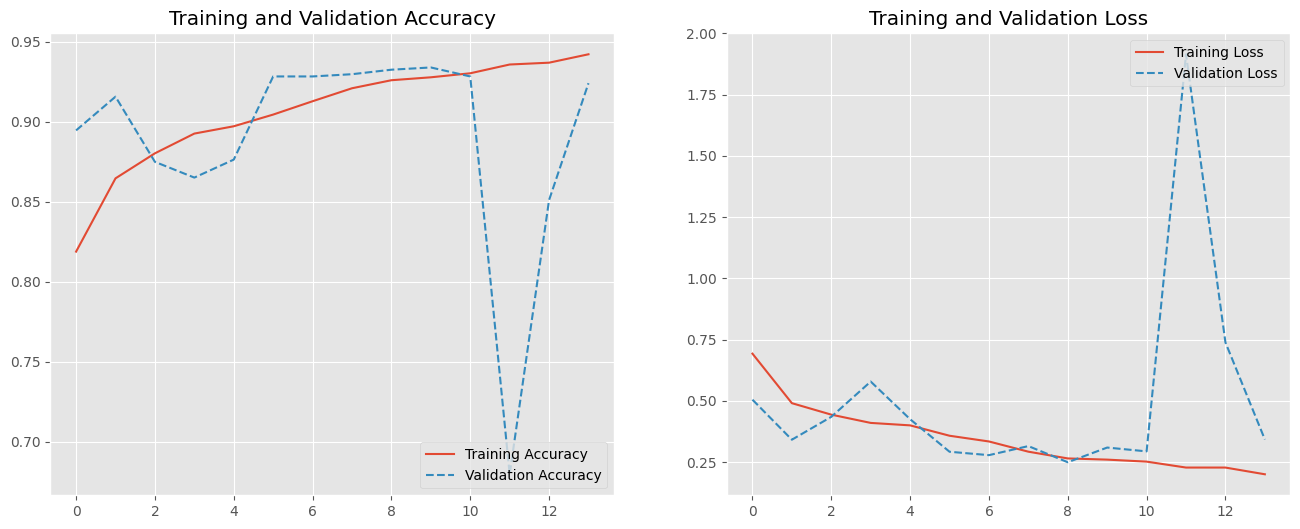

In [ ]:
plot_result(history)

In [ ]:
#load model
model = tf.keras.models.load_model('./VGG19_model.h5')

In [ ]:
pred = model.evaluate(test_gen)

7/7 [==============================] - 89s 9s/step - loss: 0.4504 - accuracy: 0.9482


Evaluate model with test set:
1/1 [==============================] - 0s 170ms/step
Accuracy:  0.9481668773704172
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       242
           1       0.98      0.95      0.96       549

    accuracy                           0.95       791
   macro avg       0.93      0.95      0.94       791
weighted avg       0.95      0.95      0.95       791



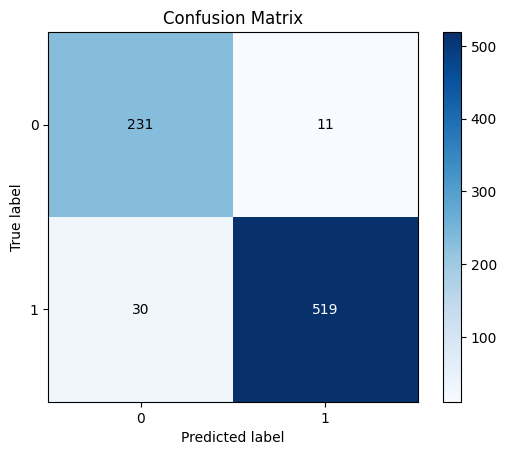

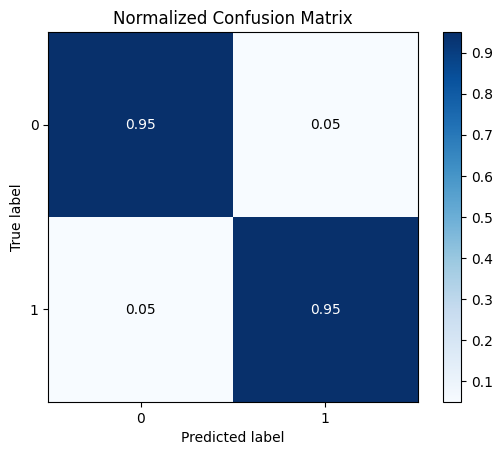

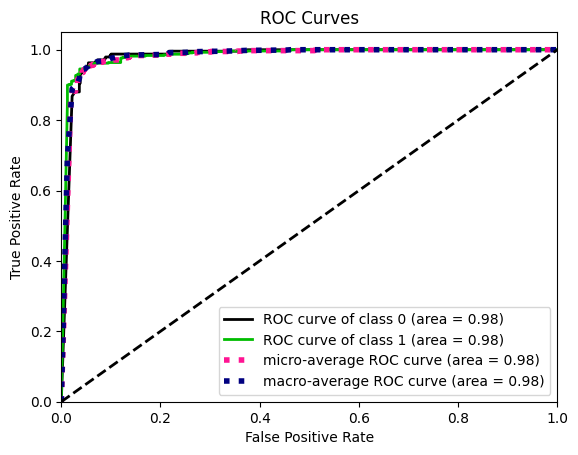

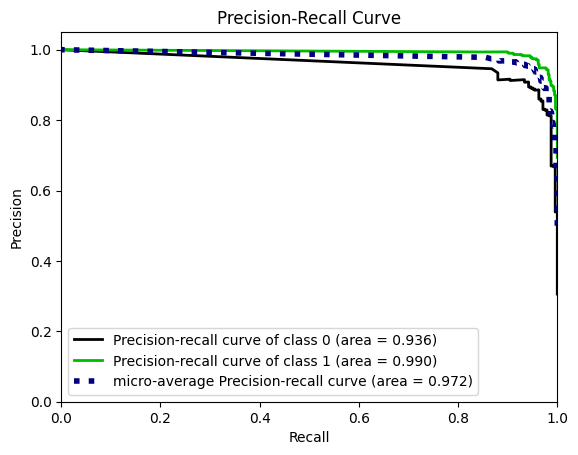

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen,model)

### MSB

#### 40x

In [ ]:
train_generation = dataset("./msb/40/training_image/",train = True)
val_generation = dataset("./msb/40/validating_image/",train = False)
test_gen = dataset("./msb/40/testing_image/",train = False)

Found 2158 files belonging to 2 classes.
Found 192 files belonging to 2 classes.
Found 204 files belonging to 2 classes.


In [ ]:
#build the model
model = vgg19_builder()
model.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 14, 14, 512)  10585152    ['preprocess[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)         

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 0.8987 - accuracy: 0.7400

17/17 [==============================] - 398s 13s/step - loss: 0.8987 - accuracy: 0.7400 - val_loss: 1.2397 - val_accuracy: 0.8177
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.8531

17/17 [==============================] - 76s 4s/step - loss: 0.5224 - accuracy: 0.8531 - val_loss: 0.8451 - val_accuracy: 0.8594
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 0.3948 - accuracy: 0.8930

17/17 [==============================] - 75s 3s/step - loss: 0.3948 - accuracy: 0.8930 - val_loss: 0.5754 - val_accuracy: 0.9010
Epoch 4/50
17/17 [==============================] - 70s 3s/step - loss: 0.2959 - accuracy: 0.9087 - val_loss: 0.7251 - val_accuracy: 0.8542
Epoch 5/50
17/17 [==============================] - 70s 3s/step - loss: 0.2794 - accuracy: 0.9189 - val_loss: 0.7147 - val_accuracy: 0.8854
Epoch 6/50
17/17 [==============================] - ETA: 0s - loss: 0.2589 - accuracy: 0.9300

17/17 [==============================] - 72s 3s/step - loss: 0.2589 - accuracy: 0.9300 - val_loss: 0.4949 - val_accuracy: 0.8958
Epoch 7/50
17/17 [==============================] - ETA: 0s - loss: 0.2355 - accuracy: 0.9333

17/17 [==============================] - 72s 3s/step - loss: 0.2355 - accuracy: 0.9333 - val_loss: 0.3537 - val_accuracy: 0.9062
Epoch 8/50
17/17 [==============================] - 69s 3s/step - loss: 0.2502 - accuracy: 0.9319 - val_loss: 1.5740 - val_accuracy: 0.8073
Epoch 9/50
17/17 [==============================] - 67s 3s/step - loss: 0.2423 - accuracy: 0.9416 - val_loss: 0.3584 - val_accuracy: 0.9375
Epoch 10/50
17/17 [==============================] - 69s 3s/step - loss: 0.1517 - accuracy: 0.9555 - val_loss: 0.5200 - val_accuracy: 0.9062
Epoch 11/50
17/17 [==============================] - 87s 4s/step - loss: 0.1504 - accuracy: 0.9564 - val_loss: 1.2551 - val_accuracy: 0.7917
Epoch 12/50
17/17 [==============================] - 69s 3s/step - loss: 0.1466 - accuracy: 0.9574 - val_loss: 0.6199 - val_accuracy: 0.9062


In [ ]:
model.save('VGG19_inception_40_model.h5')

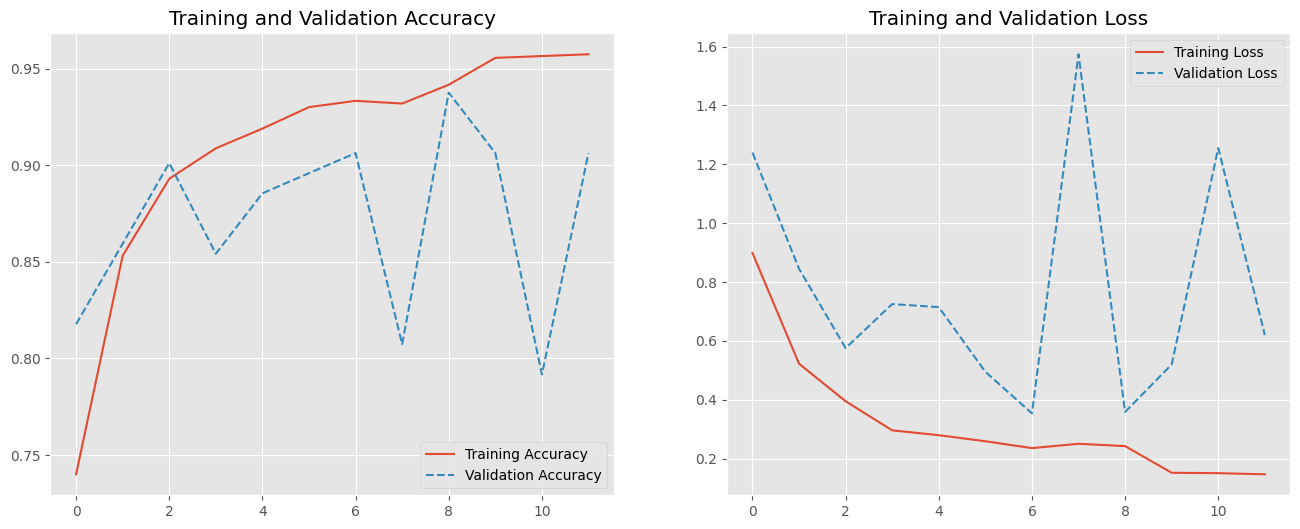

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./VGG19_inception_40_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 24s 10s/step - loss: 0.2337 - accuracy: 0.9412


Evaluate model with test set:
3/3 [==============================] - 3s 1s/step
Accuracy:  0.9411764705882353
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        58
           1       0.97      0.95      0.96       146

    accuracy                           0.94       204
   macro avg       0.92      0.94      0.93       204
weighted avg       0.94      0.94      0.94       204



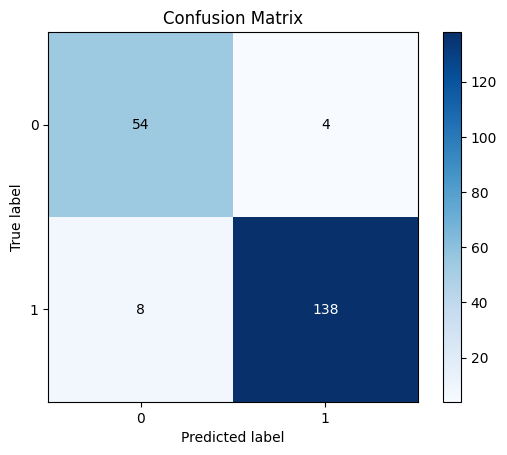

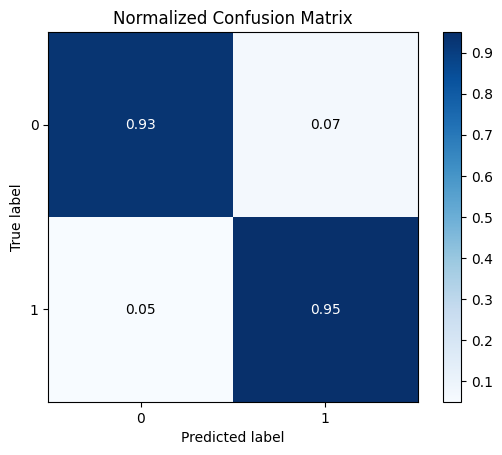

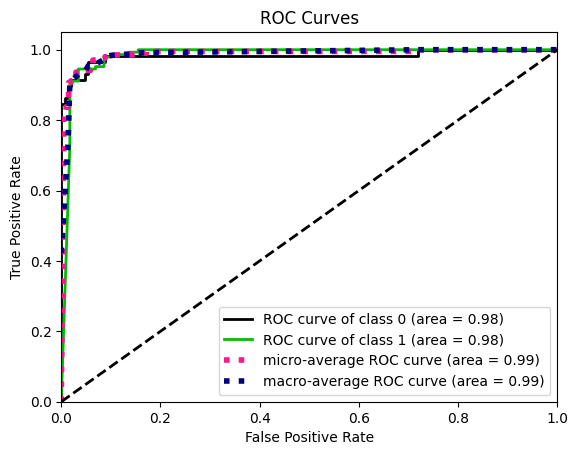

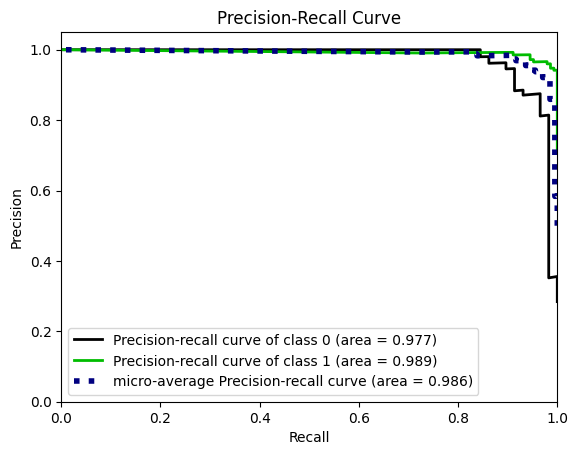

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

#### 100X

In [ ]:
train_generation = dataset("./msb/100/training_image/",train = True)
val_generation = dataset("./msb/100/validating_image/",train = False)
test_gen = dataset("./msb/100/testing_image/",train = False)

Found 2389 files belonging to 2 classes.
Found 175 files belonging to 2 classes.
Found 190 files belonging to 2 classes.


In [ ]:
#build the model
model = vgg19_builder()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 model_3 (Functional)           (None, 14, 14, 512)  10585152    ['preprocess[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)              (None, 14, 14, 64)   32832       ['model_3[0][0]']          

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
19/19 [==============================] - ETA: 0s - loss: 1.0114 - accuracy: 0.7576

19/19 [==============================] - 400s 12s/step - loss: 1.0114 - accuracy: 0.7576 - val_loss: 0.7301 - val_accuracy: 0.9314
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.8527

19/19 [==============================] - 77s 3s/step - loss: 0.5224 - accuracy: 0.8527 - val_loss: 0.4111 - val_accuracy: 0.9314
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.9041

19/19 [==============================] - 75s 3s/step - loss: 0.3302 - accuracy: 0.9041 - val_loss: 0.3343 - val_accuracy: 0.9314
Epoch 4/50
19/19 [==============================] - 67s 3s/step - loss: 0.3600 - accuracy: 0.9108 - val_loss: 0.4184 - val_accuracy: 0.9429
Epoch 5/50
19/19 [==============================] - 66s 3s/step - loss: 0.3256 - accuracy: 0.9100 - val_loss: 0.7885 - val_accuracy: 0.8514
Epoch 6/50
19/19 [==============================] - 69s 3s/step - loss: 0.3154 - accuracy: 0.9142 - val_loss: 0.5670 - val_accuracy: 0.8971
Epoch 7/50
19/19 [==============================] - 67s 3s/step - loss: 0.2683 - accuracy: 0.9314 - val_loss: 0.3672 - val_accuracy: 0.9371
Epoch 8/50
19/19 [==============================] - 67s 3s/step - loss: 0.2506 - accuracy: 0.9288 - val_loss: 0.3474 - val_accuracy: 0.9257


In [ ]:
model.save('VGG19_inception_100_model.h5')

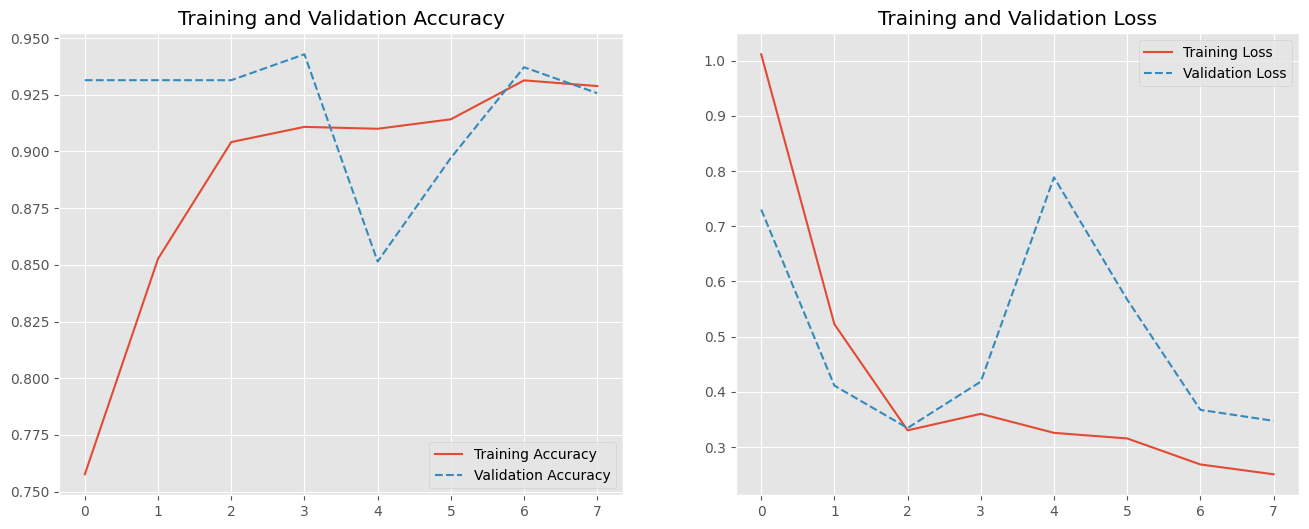

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./VGG19_inception_100_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 20s 8s/step - loss: 0.2654 - accuracy: 0.9526


Evaluate model with test set:


2/2 [==============================] - 5s 5s/step
Accuracy:  0.9526315789473684
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        55
           1       0.99      0.94      0.97       135

    accuracy                           0.95       190
   macro avg       0.93      0.96      0.94       190
weighted avg       0.96      0.95      0.95       190



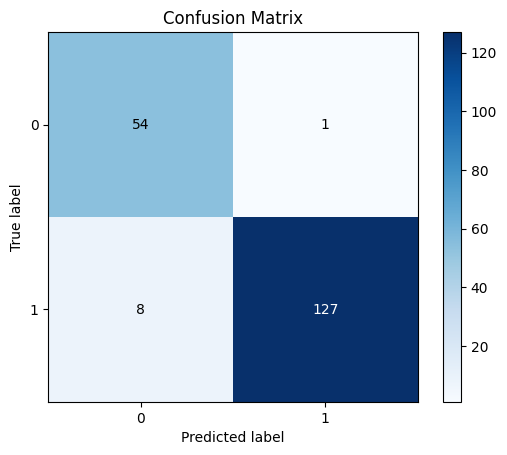

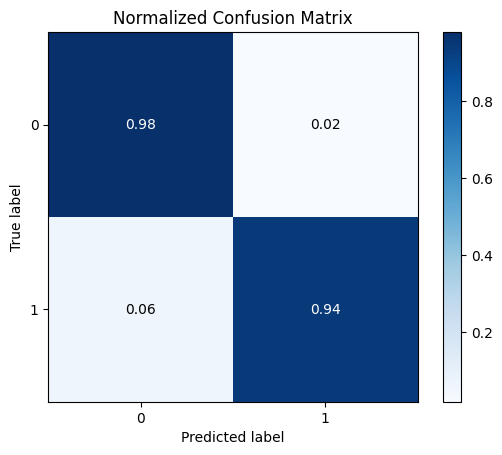

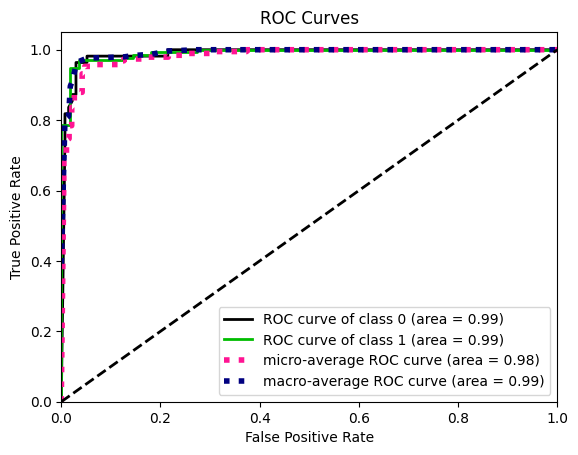

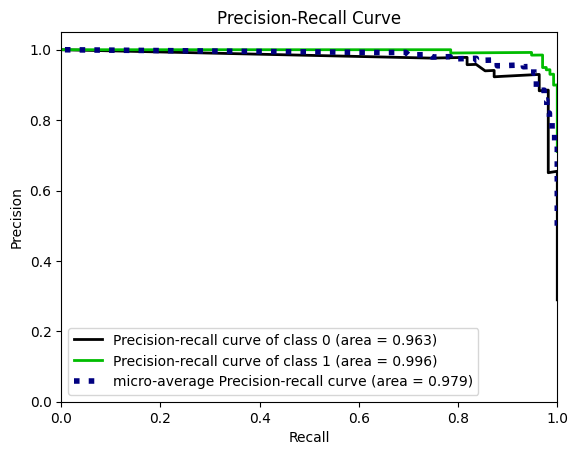

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

#### 200X

In [ ]:
train_generation = dataset("./msb/200/training_image/",train = True)
val_generation = dataset("./msb/200/validating_image/",train = False)
test_gen = dataset("./msb/200/testing_image/",train = False)

Found 2215 files belonging to 2 classes.
Found 191 files belonging to 2 classes.
Found 211 files belonging to 2 classes.


In [ ]:
#build the model
model = vgg19_builder()
model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 14, 14, 512)  10585152    ['preprocess[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)         

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
18/18 [==============================] - ETA: 0s - loss: 0.9031 - accuracy: 0.7585

18/18 [==============================] - 266s 8s/step - loss: 0.9031 - accuracy: 0.7585 - val_loss: 2.4302 - val_accuracy: 0.7644
Epoch 2/50
18/18 [==============================] - ETA: 0s - loss: 0.5466 - accuracy: 0.8609

18/18 [==============================] - 74s 3s/step - loss: 0.5466 - accuracy: 0.8609 - val_loss: 0.5910 - val_accuracy: 0.9058
Epoch 3/50
18/18 [==============================] - 63s 3s/step - loss: 0.4191 - accuracy: 0.8808 - val_loss: 0.8273 - val_accuracy: 0.8796
Epoch 4/50
18/18 [==============================] - ETA: 0s - loss: 0.3847 - accuracy: 0.8975

18/18 [==============================] - 70s 3s/step - loss: 0.3847 - accuracy: 0.8975 - val_loss: 0.3756 - val_accuracy: 0.9319
Epoch 5/50
18/18 [==============================] - 64s 3s/step - loss: 0.3379 - accuracy: 0.9120 - val_loss: 0.4009 - val_accuracy: 0.9319
Epoch 6/50
18/18 [==============================] - ETA: 0s - loss: 0.2852 - accuracy: 0.9183

18/18 [==============================] - 65s 3s/step - loss: 0.2852 - accuracy: 0.9183 - val_loss: 0.2416 - val_accuracy: 0.9476
Epoch 7/50
18/18 [==============================] - 63s 3s/step - loss: 0.3758 - accuracy: 0.9093 - val_loss: 0.2943 - val_accuracy: 0.9476
Epoch 8/50
18/18 [==============================] - 62s 3s/step - loss: 0.3451 - accuracy: 0.9133 - val_loss: 0.2522 - val_accuracy: 0.9476
Epoch 9/50
18/18 [==============================] - 64s 3s/step - loss: 0.2944 - accuracy: 0.9192 - val_loss: 0.4496 - val_accuracy: 0.9162
Epoch 10/50
18/18 [==============================] - 62s 3s/step - loss: 0.2963 - accuracy: 0.9233 - val_loss: 0.2910 - val_accuracy: 0.9424
Epoch 11/50
18/18 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.9305

18/18 [==============================] - 66s 3s/step - loss: 0.2708 - accuracy: 0.9305 - val_loss: 0.2258 - val_accuracy: 0.9424
Epoch 12/50
18/18 [==============================] - 61s 3s/step - loss: 0.2369 - accuracy: 0.9345 - val_loss: 0.2701 - val_accuracy: 0.9424
Epoch 13/50
18/18 [==============================] - 63s 3s/step - loss: 0.2419 - accuracy: 0.9332 - val_loss: 0.2615 - val_accuracy: 0.9319
Epoch 14/50
18/18 [==============================] - 62s 3s/step - loss: 0.2076 - accuracy: 0.9418 - val_loss: 0.2838 - val_accuracy: 0.9372
Epoch 15/50
18/18 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9481

18/18 [==============================] - 67s 3s/step - loss: 0.1976 - accuracy: 0.9481 - val_loss: 0.1351 - val_accuracy: 0.9581
Epoch 16/50
18/18 [==============================] - 68s 3s/step - loss: 0.1924 - accuracy: 0.9458 - val_loss: 0.1574 - val_accuracy: 0.9529
Epoch 17/50
18/18 [==============================] - 67s 3s/step - loss: 0.1860 - accuracy: 0.9485 - val_loss: 0.6546 - val_accuracy: 0.8953
Epoch 18/50
18/18 [==============================] - 71s 3s/step - loss: 0.1738 - accuracy: 0.9499 - val_loss: 0.1410 - val_accuracy: 0.9738
Epoch 19/50
18/18 [==============================] - 69s 3s/step - loss: 0.1808 - accuracy: 0.9544 - val_loss: 0.2957 - val_accuracy: 0.9424
Epoch 20/50
18/18 [==============================] - 65s 3s/step - loss: 0.1403 - accuracy: 0.9571 - val_loss: 0.3601 - val_accuracy: 0.9162


In [ ]:
model.save('VGG_inception_200_model.h5')

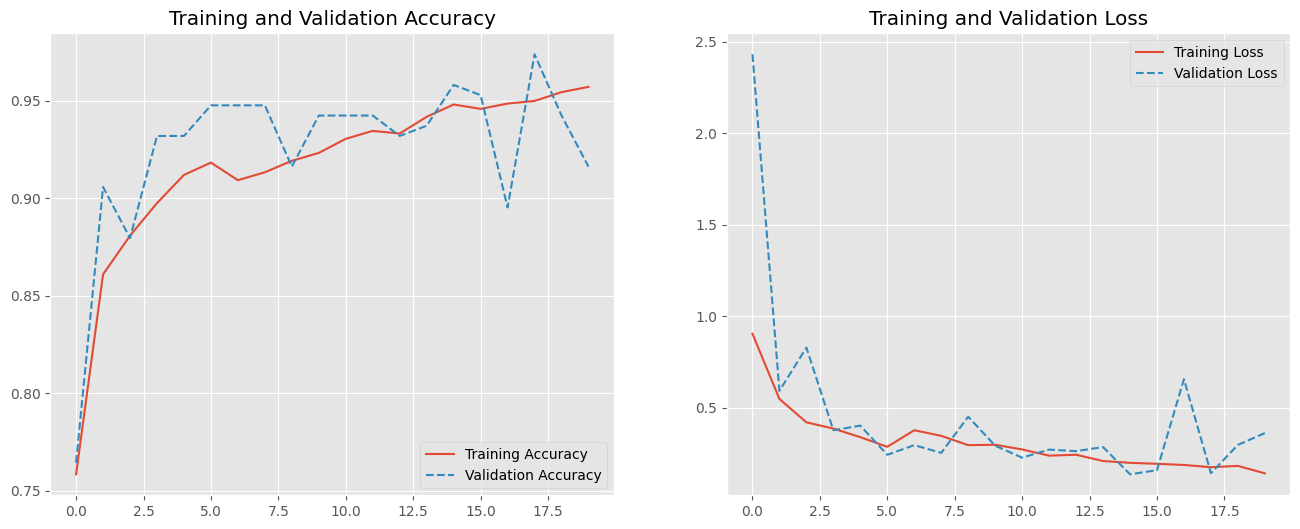

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./VGG19_inception_200_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 3s 603ms/step - loss: 0.4690 - accuracy: 0.9100


Evaluate model with test set:
3/3 [==============================] - 0s 138ms/step
Accuracy:  0.909952606635071
              precision    recall  f1-score   support

           0       0.79      0.95      0.87        64
           1       0.98      0.89      0.93       147

    accuracy                           0.91       211
   macro avg       0.88      0.92      0.90       211
weighted avg       0.92      0.91      0.91       211



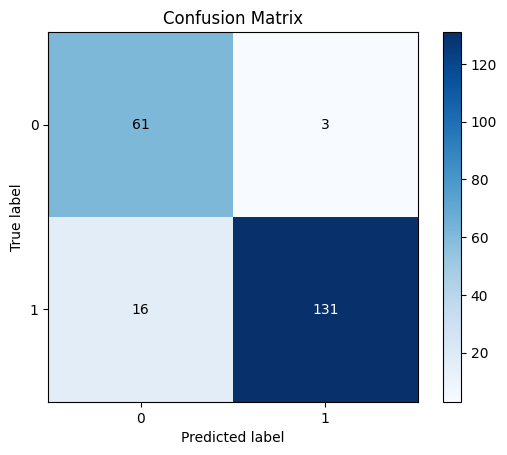

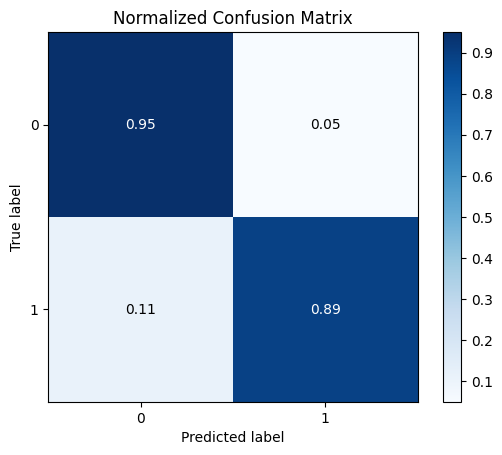

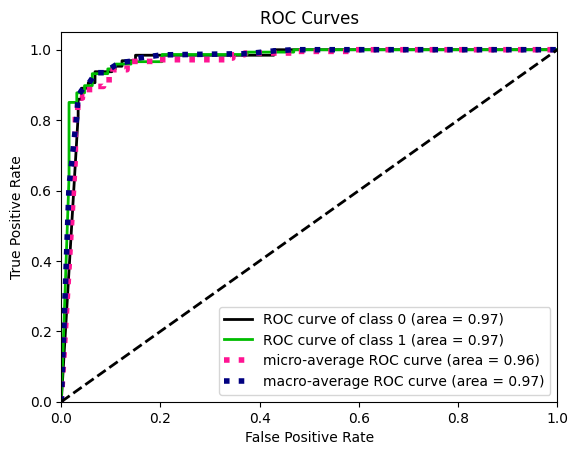

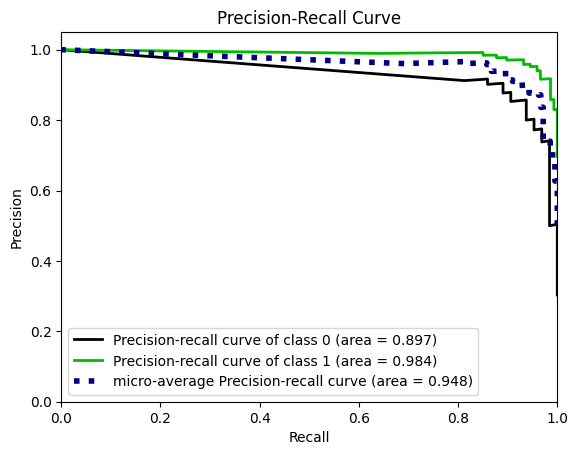

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

#### 400X

In [ ]:
train_generation = dataset("./msb/400/training_image/",train = True)
val_generation = dataset("./msb/400/validating_image/",train = False)
test_gen = dataset("./msb/400/testing_image/",train = False)

Found 1996 files belonging to 2 classes.
Found 154 files belonging to 2 classes.
Found 186 files belonging to 2 classes.


In [ ]:
#build the model
model = vgg19_builder()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 model_3 (Functional)           (None, 14, 14, 512)  10585152    ['preprocess[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)              (None, 14, 14, 64)   32832       ['model_3[0][0]']          

In [ ]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Train model for 50 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.8831 - accuracy: 0.7495

16/16 [==============================] - 241s 8s/step - loss: 0.8831 - accuracy: 0.7495 - val_loss: 1.4657 - val_accuracy: 0.8117
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.6039 - accuracy: 0.8332

16/16 [==============================] - 66s 3s/step - loss: 0.6039 - accuracy: 0.8332 - val_loss: 1.0597 - val_accuracy: 0.8506
Epoch 3/50
16/16 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.8597

16/16 [==============================] - 66s 3s/step - loss: 0.5228 - accuracy: 0.8597 - val_loss: 0.6669 - val_accuracy: 0.8766
Epoch 4/50
16/16 [==============================] - 61s 3s/step - loss: 0.4798 - accuracy: 0.8753 - val_loss: 0.6713 - val_accuracy: 0.8766
Epoch 5/50
16/16 [==============================] - ETA: 0s - loss: 0.4941 - accuracy: 0.8652

16/16 [==============================] - 63s 3s/step - loss: 0.4941 - accuracy: 0.8652 - val_loss: 0.5664 - val_accuracy: 0.8636
Epoch 6/50
16/16 [==============================] - 61s 3s/step - loss: 0.5630 - accuracy: 0.8557 - val_loss: 0.6967 - val_accuracy: 0.8506
Epoch 7/50
16/16 [==============================] - ETA: 0s - loss: 0.4166 - accuracy: 0.8943

16/16 [==============================] - 66s 3s/step - loss: 0.4166 - accuracy: 0.8943 - val_loss: 0.3760 - val_accuracy: 0.9091
Epoch 8/50
16/16 [==============================] - 60s 3s/step - loss: 0.4200 - accuracy: 0.8958 - val_loss: 0.3937 - val_accuracy: 0.9156
Epoch 9/50
16/16 [==============================] - 61s 3s/step - loss: 0.3601 - accuracy: 0.9103 - val_loss: 0.4160 - val_accuracy: 0.9286
Epoch 10/50
16/16 [==============================] - 63s 3s/step - loss: 0.3435 - accuracy: 0.9028 - val_loss: 0.4598 - val_accuracy: 0.9221
Epoch 11/50
16/16 [==============================] - 62s 3s/step - loss: 0.3826 - accuracy: 0.9048 - val_loss: 0.4322 - val_accuracy: 0.9091
Epoch 12/50
16/16 [==============================] - 63s 3s/step - loss: 0.3208 - accuracy: 0.9053 - val_loss: 0.3840 - val_accuracy: 0.9221


In [ ]:
model.save('VGG19_inception_400_model.h5')

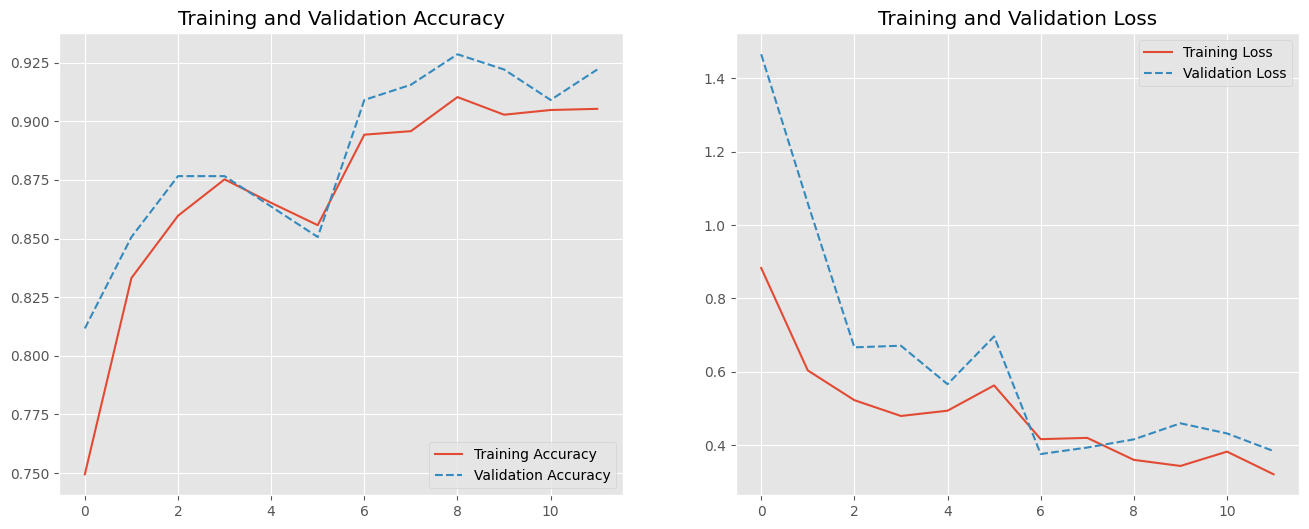

In [ ]:
plot_result(history)

In [ ]:
#model = tf.keras.models.load_model("./VGG19_inception_400_model.h5")

In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 30s 13s/step - loss: 0.3431 - accuracy: 0.9140


Evaluate model with test set:
2/2 [==============================] - 0s 136ms/step
Accuracy:  0.9139784946236559
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        65
           1       0.95      0.92      0.93       121

    accuracy                           0.91       186
   macro avg       0.90      0.91      0.91       186
weighted avg       0.92      0.91      0.91       186



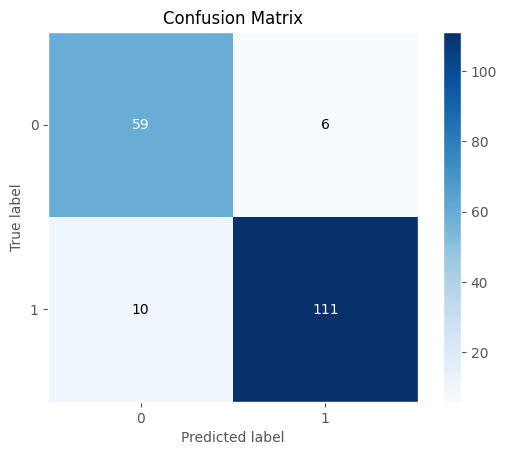

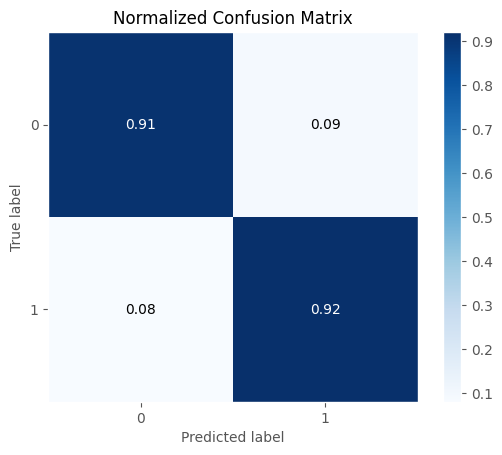

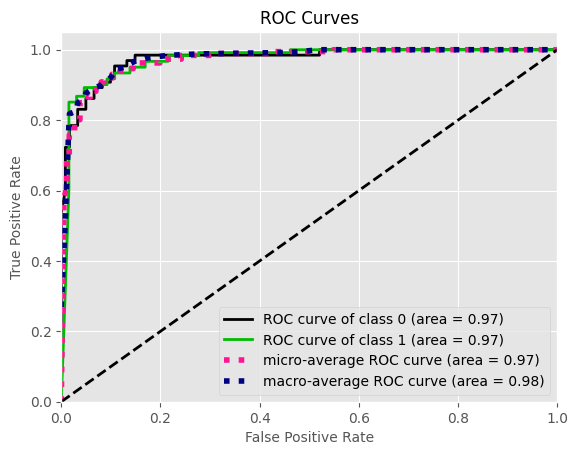

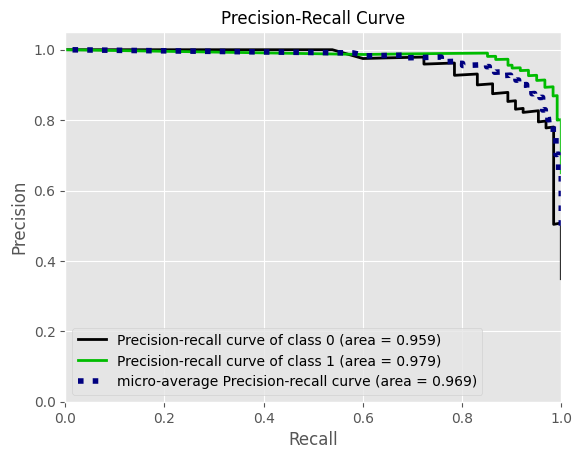

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

###MIM

In [ ]:
train_generation = dataset("./subclass/training_image/",train = True)
val_generation = dataset("./subclass/validating_image/",train = False)
test_gen = dataset("./subclass/testing_image/",train = False)

Found 8758 files belonging to 8 classes.
Found 712 files belonging to 8 classes.
Found 791 files belonging to 8 classes.


In [ ]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=1000,
  decay_rate=1,
  staircase=False)

In [ ]:
def vgg19_Mbuilder():
    base_model = VGG19(include_top=False, input_shape=(224, 224, 3))
    stop_layer = 'block4_pool'
    pre_model = Model(inputs = base_model.input, outputs = base_model.get_layer(stop_layer).output)
    pre_model.trainable = False

    preprocess_layer = Lambda(vgg_preprocess, name = 'preprocess')
    image = Input((224, 224, 3))
    preprocess_tensor = preprocess_layer(image)

    pre_out = pre_model(preprocess_tensor)
    pre_model = Model(inputs = image , outputs = pre_out)

    def dimension_reductions_inception_module(input_layer):
        # 1x1 conv
        conv1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        # 1x1 & 3x3 conv
        conv1_3 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        conv3_3 = Conv2D(128, (3,3), padding='same', activation='relu')(conv1_3)
        # 1x1 & 5x5 conv
        conv1_5 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
        conv5_5 = Conv2D(32, (5,5), padding='same', activation='relu')(conv1_5)
        # 3x3 max pooling & 1x1
        pool_1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_layer)
        conv1_p = Conv2D(64, (1,1), padding='same', activation='relu')(pool_1)
        # concatenate filters
        output_layer = Concatenate()([conv1, conv3_3, conv5_5, conv1_p])

        return output_layer

    fin_out = dimension_reductions_inception_module(pre_model.output)
    b_norm = BatchNormalization()(fin_out)
    flat = Flatten()(b_norm)
    drop = Dropout(0.4)(flat)
    dense = Dense(8, activation='softmax')(drop)

    final_model = Model(inputs = pre_model.input, outputs = dense)

    return final_model

In [ ]:
#Defining the base model
model = vgg19_Mbuilder()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 preprocess (Lambda)            (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 model (Functional)             (None, 14, 14, 512)  10585152    ['preprocess[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   32832       ['model[0][0]']            

In [ ]:
#Compiling the model
model.compile(loss='CategoricalCrossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)

In [ ]:
#Model is fitted using train and validation generator for 100 epochs
history = model.fit(train_generation, validation_data=val_generation,batch_size=BATCH_SIZE,epochs=50,
                 callbacks=[early_stop,checkpoint], verbose = 1)

Epoch 1/50
69/69 [==============================] - ETA: 0s - loss: 2.8089 - accuracy: 0.4503

69/69 [==============================] - 675s 9s/step - loss: 2.8089 - accuracy: 0.4503 - val_loss: 4.4958 - val_accuracy: 0.4199
Epoch 2/50
69/69 [==============================] - ETA: 0s - loss: 2.3028 - accuracy: 0.5257

69/69 [==============================] - 264s 4s/step - loss: 2.3028 - accuracy: 0.5257 - val_loss: 3.3335 - val_accuracy: 0.5913
Epoch 3/50
69/69 [==============================] - 267s 4s/step - loss: 2.1253 - accuracy: 0.5800 - val_loss: 4.9201 - val_accuracy: 0.3553
Epoch 4/50
69/69 [==============================] - ETA: 0s - loss: 1.9137 - accuracy: 0.6047

69/69 [==============================] - 266s 4s/step - loss: 1.9137 - accuracy: 0.6047 - val_loss: 2.1704 - val_accuracy: 0.5730
Epoch 5/50
69/69 [==============================] - 276s 4s/step - loss: 1.7173 - accuracy: 0.6403 - val_loss: 3.1416 - val_accuracy: 0.5772
Epoch 6/50
69/69 [==============================] - 263s 4s/step - loss: 1.5851 - accuracy: 0.6568 - val_loss: 2.5609 - val_accuracy: 0.5772
Epoch 7/50
69/69 [==============================] - ETA: 0s - loss: 1.4455 - accuracy: 0.6784

69/69 [==============================] - 269s 4s/step - loss: 1.4455 - accuracy: 0.6784 - val_loss: 1.8220 - val_accuracy: 0.6236
Epoch 8/50
69/69 [==============================] - 264s 4s/step - loss: 1.3112 - accuracy: 0.6905 - val_loss: 2.4782 - val_accuracy: 0.5646
Epoch 9/50
69/69 [==============================] - 266s 4s/step - loss: 1.2496 - accuracy: 0.7040 - val_loss: 2.0692 - val_accuracy: 0.6194
Epoch 10/50
69/69 [==============================] - 276s 4s/step - loss: 1.1827 - accuracy: 0.7147 - val_loss: 2.3280 - val_accuracy: 0.6081
Epoch 11/50
69/69 [==============================] - ETA: 0s - loss: 1.1805 - accuracy: 0.7129

69/69 [==============================] - 285s 4s/step - loss: 1.1805 - accuracy: 0.7129 - val_loss: 1.5128 - val_accuracy: 0.6924
Epoch 12/50
69/69 [==============================] - 296s 4s/step - loss: 1.0965 - accuracy: 0.7329 - val_loss: 2.1207 - val_accuracy: 0.6096
Epoch 13/50
69/69 [==============================] - 285s 4s/step - loss: 1.0036 - accuracy: 0.7412 - val_loss: 1.6906 - val_accuracy: 0.6503
Epoch 14/50
69/69 [==============================] - ETA: 0s - loss: 0.9572 - accuracy: 0.7490

69/69 [==============================] - 291s 4s/step - loss: 0.9572 - accuracy: 0.7490 - val_loss: 1.3270 - val_accuracy: 0.6882
Epoch 15/50
69/69 [==============================] - ETA: 0s - loss: 0.9137 - accuracy: 0.7585

69/69 [==============================] - 294s 4s/step - loss: 0.9137 - accuracy: 0.7585 - val_loss: 1.1093 - val_accuracy: 0.7612
Epoch 16/50
69/69 [==============================] - 286s 4s/step - loss: 0.9002 - accuracy: 0.7666 - val_loss: 1.5590 - val_accuracy: 0.6924
Epoch 17/50
69/69 [==============================] - 286s 4s/step - loss: 0.8499 - accuracy: 0.7739 - val_loss: 1.2367 - val_accuracy: 0.7107
Epoch 18/50
69/69 [==============================] - 292s 4s/step - loss: 0.8215 - accuracy: 0.7745 - val_loss: 1.2959 - val_accuracy: 0.7486
Epoch 19/50
69/69 [==============================] - 290s 4s/step - loss: 0.7848 - accuracy: 0.7849 - val_loss: 1.2433 - val_accuracy: 0.7584
Epoch 20/50
69/69 [==============================] - 289s 4s/step - loss: 0.7500 - accuracy: 0.7941 - val_loss: 1.4541 - val_accuracy: 0.7360


In [ ]:
model.save('VGG19_Inception_MModel.h5')

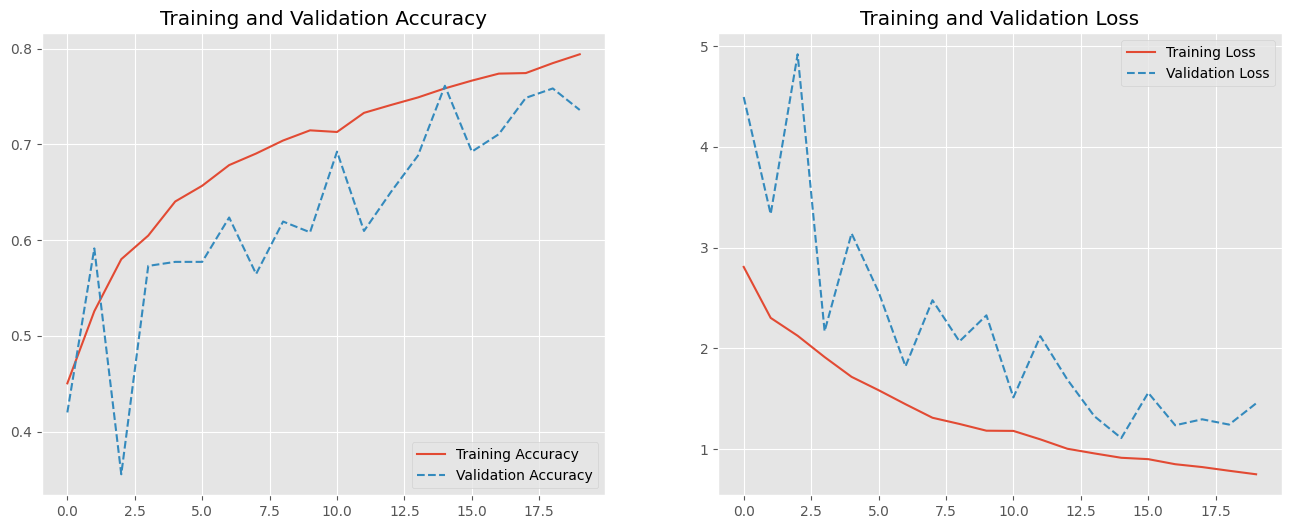

In [ ]:
plot_result(history)

Evaluate model with test set:
1/1 [==============================] - 4s 4s/step
Accuracy:  0.7117572692793932
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        45
           1       0.83      0.78      0.80       339
           2       0.70      0.72      0.71        95
           3       0.67      0.42      0.52        66
           4       0.73      0.59      0.65        88
           5       0.36      0.88      0.51        56
           6       0.87      0.41      0.56        49
           7       0.77      0.91      0.83        53

    accuracy                           0.71       791
   macro avg       0.71      0.68      0.67       791
weighted avg       0.75      0.71      0.72       791



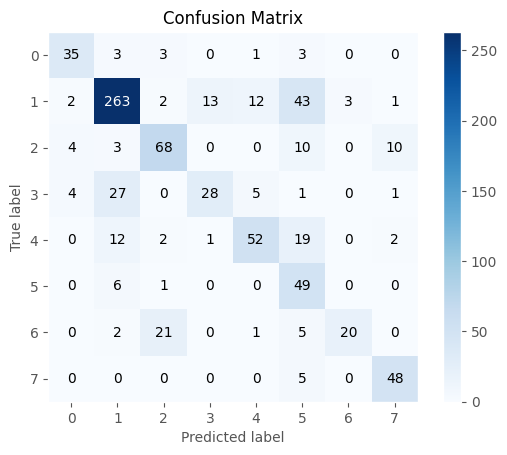

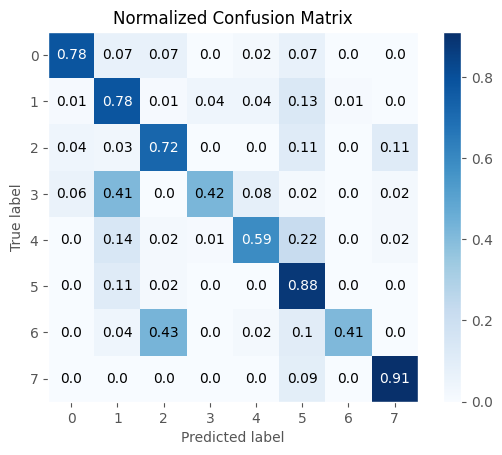

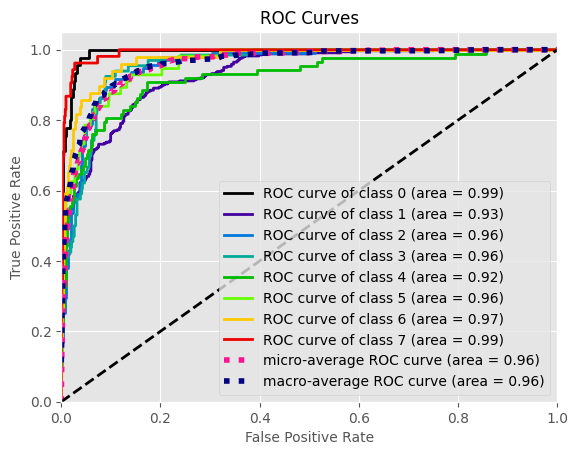

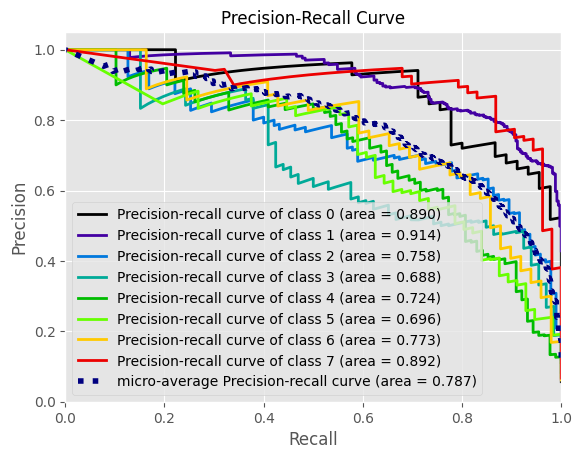

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

### MIM mag test

In [ ]:
model = tf.keras.models.load_model("./VGG19_Inception_MModel.h5")

####40x

In [ ]:
test_gen = dataset("./mag_test/40/",train = False)

Found 204 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 50s 9s/step - loss: 1.0966 - accuracy: 0.7108


Evaluate model with test set:
3/3 [==============================] - 2s 1s/step
Accuracy:  0.7107843137254902
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.79      0.74      0.77        82
           2       0.59      0.77      0.67        22
           3       0.64      0.37      0.47        19
           4       0.80      0.83      0.82        24
           5       0.47      0.81      0.60        21
           6       1.00      0.25      0.40        16
           7       0.91      1.00      0.95        10

    accuracy                           0.71       204
   macro avg       0.75      0.71      0.69       204
weighted avg       0.75      0.71      0.70       204



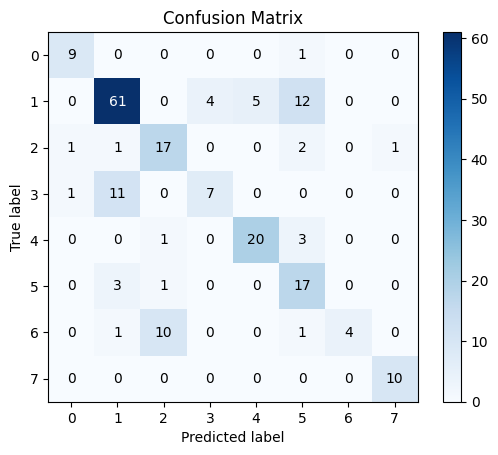

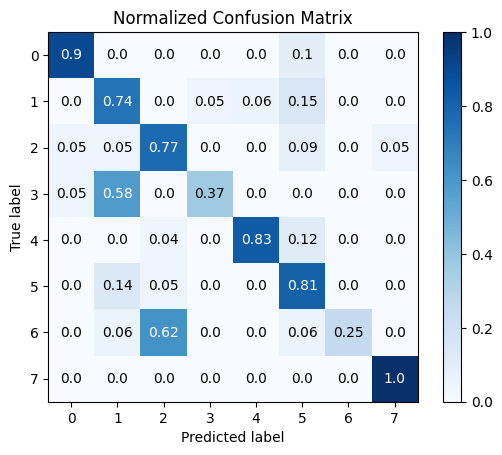

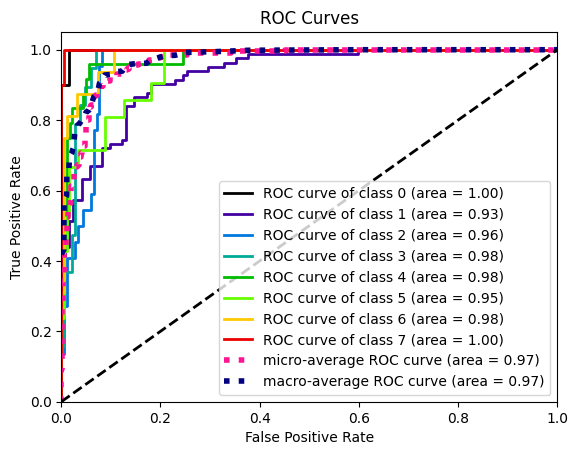

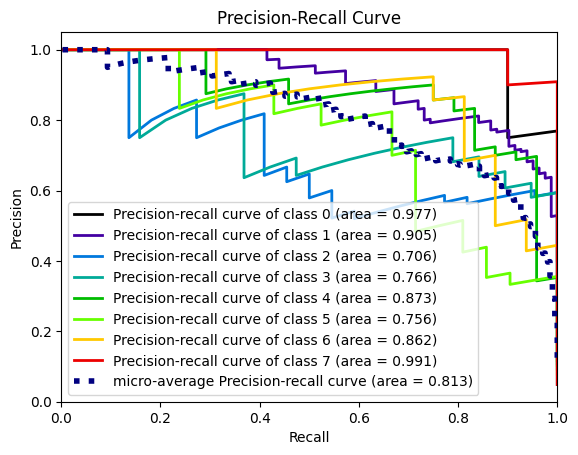

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####100x

In [ ]:
test_gen = dataset("./mag_test/100/",train = False)

Found 190 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 29s 14s/step - loss: 1.7149 - accuracy: 0.6947


Evaluate model with test set:
2/2 [==============================] - 4s 4s/step
Accuracy:  0.6947368421052632
              precision    recall  f1-score   support

           0       0.50      0.78      0.61         9
           1       0.94      0.69      0.79        89
           2       0.67      0.72      0.69        25
           3       0.82      0.64      0.72        14
           4       0.81      0.54      0.65        24
           5       0.21      1.00      0.35         8
           6       1.00      0.38      0.55         8
           7       0.81      1.00      0.90        13

    accuracy                           0.69       190
   macro avg       0.72      0.72      0.66       190
weighted avg       0.82      0.69      0.73       190



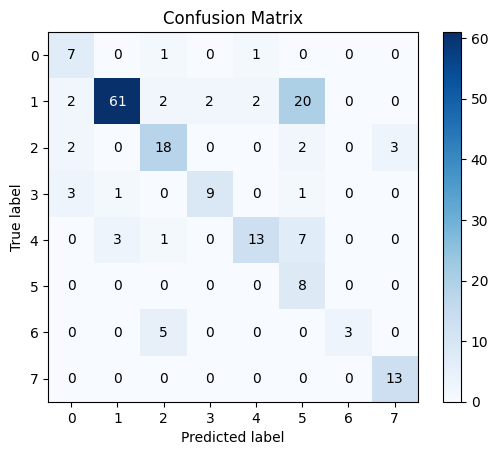

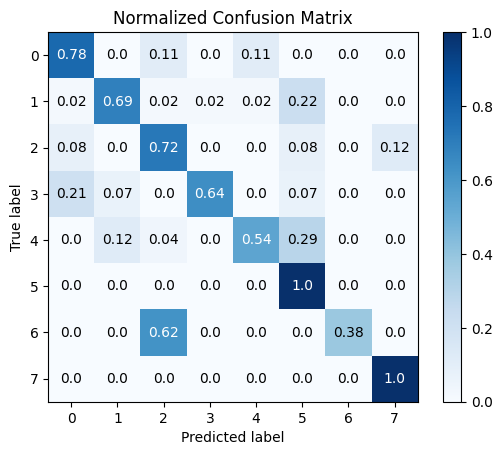

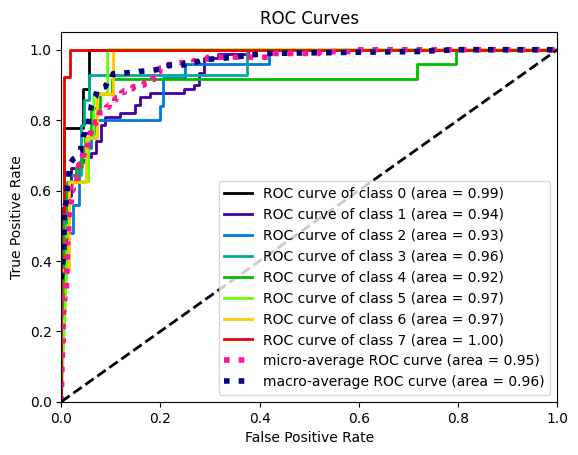

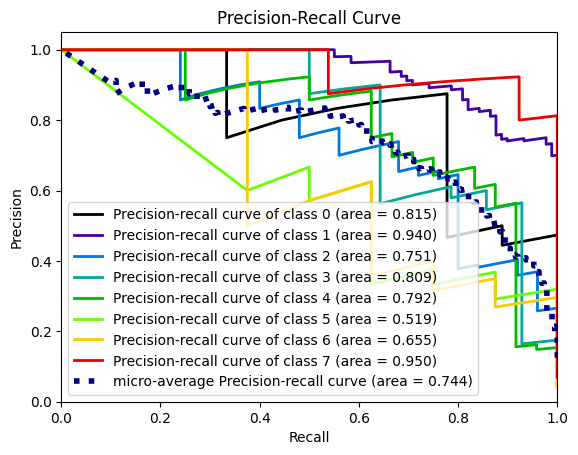

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####200x

In [ ]:
test_gen = dataset("./mag_test/200/",train = False)

Found 211 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 33s 18s/step - loss: 1.1736 - accuracy: 0.7441


Evaluate model with test set:
3/3 [==============================] - 3s 2s/step
Accuracy:  0.7440758293838863
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.82      0.86      0.84        92
           2       0.95      0.66      0.78        29
           3       0.69      0.43      0.53        21
           4       0.71      0.57      0.63        21
           5       0.41      1.00      0.58        13
           6       1.00      0.60      0.75        10
           7       0.59      0.83      0.69        12

    accuracy                           0.74       211
   macro avg       0.76      0.70      0.70       211
weighted avg       0.79      0.74      0.75       211



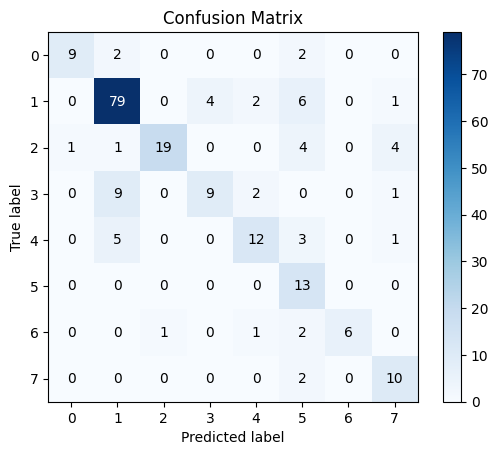

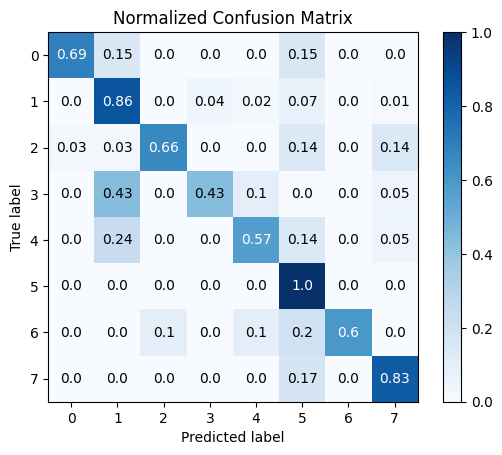

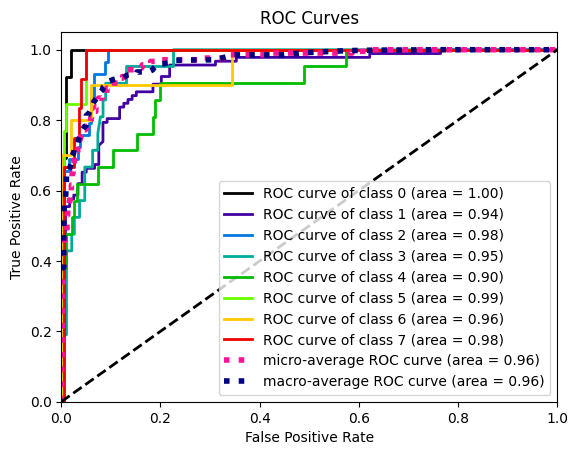

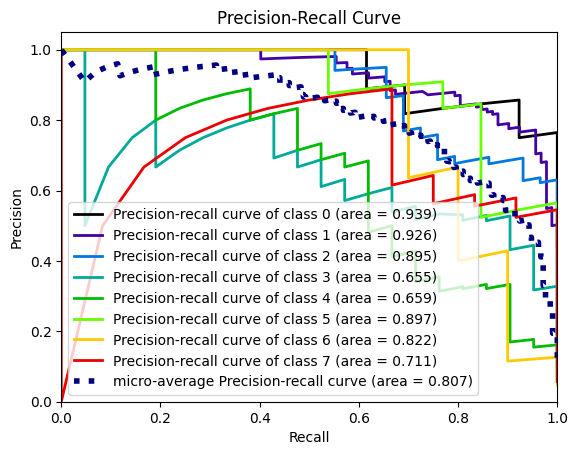

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)

####400x

In [ ]:
test_gen = dataset("./mag_test/400/",train = False)

Found 186 files belonging to 8 classes.


In [ ]:
pred = model.evaluate(test_gen)

2/2 [==============================] - 27s 13s/step - loss: 1.2843 - accuracy: 0.6935


Evaluate model with test set:
2/2 [==============================] - 4s 4s/step
Accuracy:  0.6935483870967742
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        13
           1       0.79      0.82      0.81        76
           2       0.67      0.74      0.70        19
           3       0.43      0.25      0.32        12
           4       0.54      0.37      0.44        19
           5       0.38      0.79      0.51        14
           6       0.70      0.47      0.56        15
           7       0.83      0.83      0.83        18

    accuracy                           0.69       186
   macro avg       0.67      0.63      0.63       186
weighted avg       0.71      0.69      0.69       186



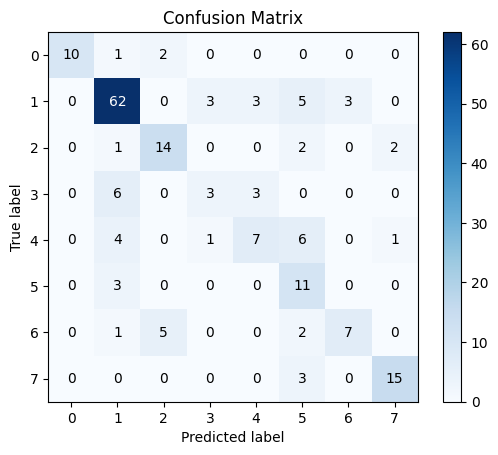

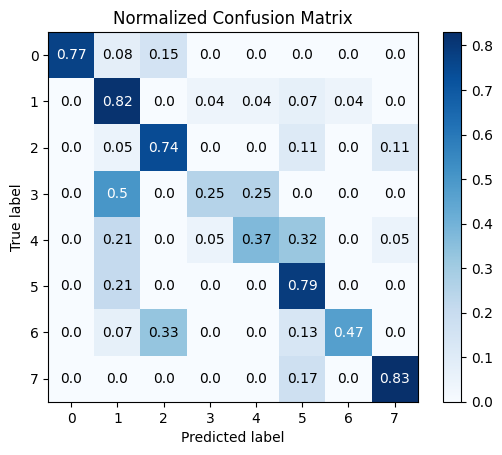

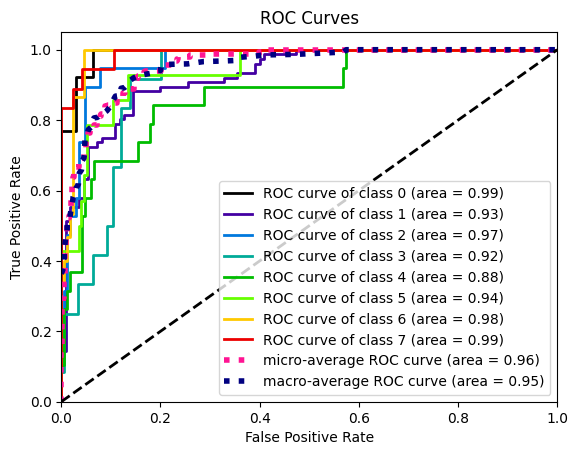

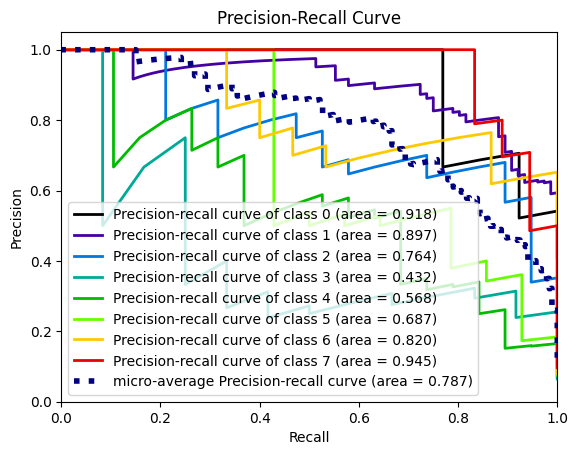

In [ ]:
print("Evaluate model with test set:")
evaluate_report(test_gen, model = model)